<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [2]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [3]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

<h3><font color = "#079e05"> Image </font></h3>

image shape is: (1280, 961, 3)


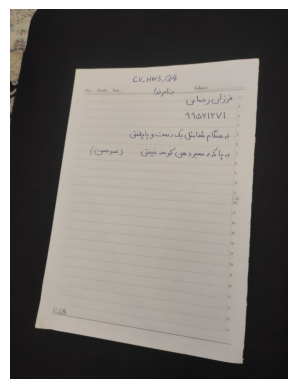

In [4]:
im = cv2.imread(os.path.join('images/Q4', 'farzan.jpg'))
imshow(im)
print("image shape is:", im.shape)

<h3><font color = "#079e05"> Process </font></h3>

<div dir="rtl">
    <h3>
        الف
    </h3>
    <p>
        تبدیل به سیاه سفید
    </p>
</div>

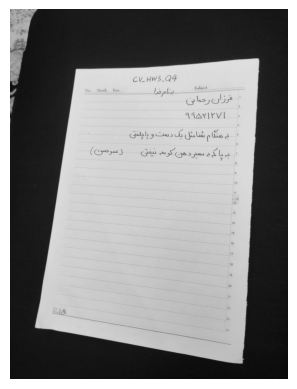

In [5]:
im_grayscale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imshow(im_grayscale)

<div dir="rtl">
    نویز گیری با استفاده از فیتر گوسی
</div>

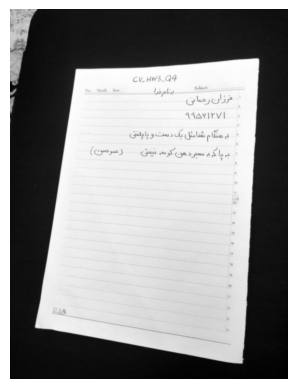

In [6]:
# remove noise with gaussian blur
averaging_blurred = cv2.blur(im_grayscale, (5, 5))
median_blurred = cv2.medianBlur(im_grayscale, 5)
im_blurred = cv2.GaussianBlur(im_grayscale, (5, 5), 0)
# im_blurred = cv2.GaussianBlur(im_grayscale, (31, 31), 0)
im_bilateral = cv2.bilateralFilter(im_grayscale, 15, 10, 10)

# imshow(averaging_blurred)
# imshow(median_blurred)
imshow(im_blurred)
# imshow(im_bilateral)


<div dir="rtl">
    پیدا کردن لبه ها با استفاده از لبه یال canny
</div>

(1280, 961)

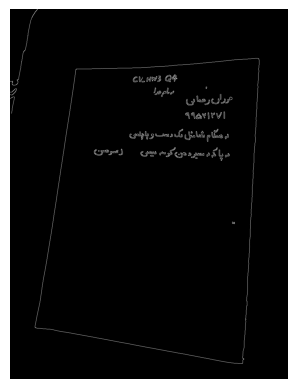

In [7]:
upper_trheshold = 100 
lower_threshold = 200 
# upper_trheshold, _ = cv2.threshold(im_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# lower_threshold = 0.5 * upper_trheshold
edges = cv2.Canny(im_blurred, lower_threshold, upper_trheshold)
imshow(edges)
im_blurred.shape

<div dir="rtl">
    <h3>
        ب)
    </h3>
    <p>
    با استفاده از تابع  findContoursکاغذ را پیدا کرده و مرز کاغذ را در تصویر مشخص کنید.
    </p>
</div>

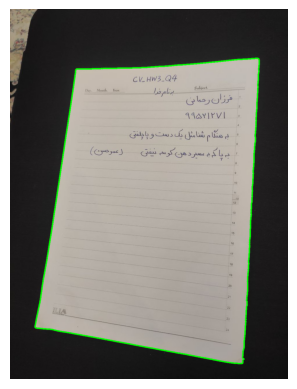

In [8]:
# find contours in the edge map
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find the contour with the largest area
max_contour = max(contours, key=cv2.contourArea)

# draw the contour on the image
im_contour = im.copy()
cv2.drawContours(im_contour, [max_contour], -1, (0, 255, 0), 3)
imshow(im_contour)


# # find contours
# contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)

# # find the contour with 4 corners
# for c in contours:
#     p = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.02 * p, True)
#     if len(approx) == 4:
#         target = approx
#         break

# # draw the contour
# im_contour = im.copy()
# cv2.drawContours(im_contour, [target], -1, (0, 255, 0), 2)
# imshow(im_contour)

<div dir="rtl">
    <h3>
        ج)
    </h3>
    <p>
    پس از انجام بخش ب تصویر زمینه اضافی را با استفاده از توابع مربوط به  Perspective Transformاز تصویر
حذف کنید.
    </p>
</div>

<div dir="rtl">
    <p>
    ابتدا نقاط گوشه شکل را پیدا می کنیم
    </p>
</div>

In [9]:
p = cv2.arcLength(max_contour, True) # perimeter
approx = cv2.approxPolyDP(max_contour, 0.02 * p, True) # approximate the polygon
# approx are the vertices of the polygon (4 corners in rectangle)

# remove the second dimention in approx (4, 1, 2) -> (4, 2)
approx = np.squeeze(approx)

print("corners:\n", approx)
approx = reorder(approx)
print("corners after being redorder:\n", approx)

corners:
 [[ 859  171]
 [ 227  209]
 [  87 1102]
 [ 804 1225]]
corners after being redorder:
 [[ 227.  209.]
 [ 859.  171.]
 [ 804. 1225.]
 [  87. 1102.]]


<div dir="rtl">
    <p>
    سپس نقاط مبدا و مقصد را برای تبدیل projective پیدا می کنیم
    سپس با استفاده از تابع warpPerspective تصویر را تبدیل می کنیم
    </p>
</div>

In [10]:
src_points = approx

# standard A4 paper size in pixels # https://www.adobe.com/uk/creativecloud/design/discover/a4-format.html#:~:text=The%20required%20resolution%20for%20an,ppi%20(pixels%20per%20inch).
A4_WIDTH = 2480
A4_HEIGHT = 3508
dst_points = np.array([[0, 0], [A4_WIDTH, 0], [A4_WIDTH, A4_HEIGHT], [0, A4_HEIGHT]], dtype=np.float32)

# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(src_points, dst_points)

# apply the perspective transformation
im_gray_result = cv2.warpPerspective(im_grayscale, M, (A4_WIDTH, A4_HEIGHT))
im_blurred_gray_result = cv2.warpPerspective(im_blurred, M, (A4_WIDTH, A4_HEIGHT))
im_bilateral_gray_result = cv2.warpPerspective(im_bilateral, M, (A4_WIDTH, A4_HEIGHT))
im_color_result = cv2.warpPerspective(im, M, (A4_WIDTH, A4_HEIGHT))
im_blurred_color_result = cv2.warpPerspective(cv2.GaussianBlur(im, (5, 5), 0), M, (A4_WIDTH, A4_HEIGHT))
im_bilateral_color_result = cv2.warpPerspective(cv2.bilateralFilter(im, 15, 10, 10), M, (A4_WIDTH, A4_HEIGHT))

<h3><font color = "#079e05"> Show the result </font></h3>

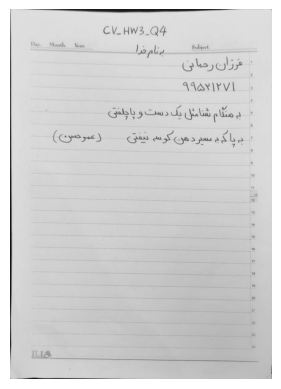

In [11]:
# histogram equalization
imshow(im_gray_result)
# imshow(im_blurred_gray_result)
# imshow(im_bilateral_gray_result)
# imshow(im_color_result)
# imshow(im_blurred_color_result)
# imshow(im_bilateral_color_result)

<Figure size 640x480 with 0 Axes>

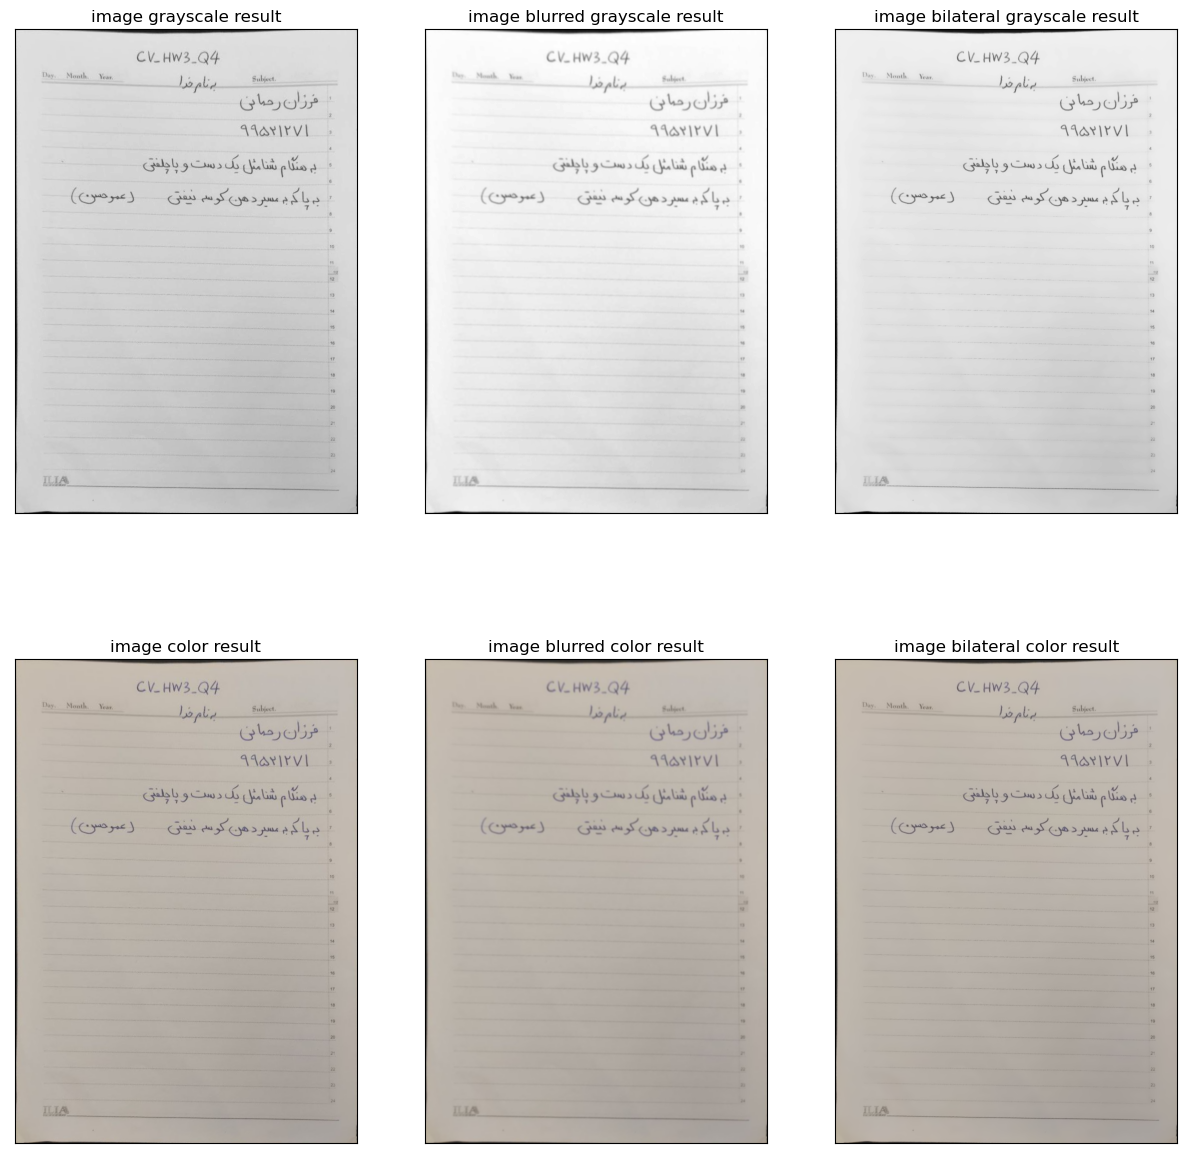

In [12]:
plt.figure()
fugure, axis = plt.subplots(2, 3, figsize=(15,15))
axis[0, 0].imshow(im_gray_result, cmap='gray')
axis[0, 0].set_title('image grayscale result')
axis[0, 1].imshow(im_blurred_gray_result, cmap='gray')
axis[0, 1].set_title('image blurred grayscale result')
axis[0, 2].imshow(im_bilateral_gray_result, cmap='gray')
axis[0, 2].set_title('image bilateral grayscale result')
axis[1, 0].imshow(im_color_result[:,:,::-1])
axis[1, 0].set_title('image color result')
axis[1, 1].imshow(im_blurred_color_result[:,:,::-1])
axis[1, 1].set_title('image blurred color result')
axis[1, 2].imshow(im_bilateral_color_result[:,:,::-1])
axis[1, 2].set_title('image bilateral color result')
# remove axis numbers
for ax in axis.flat:
    ax.set(xticks=[], yticks=[])
plt.show()

<div dir="rtl">
    <h3>
        د) 
    </h3>
    <p>
    با مواردی که تا به حال آموختهاید، چند روش برای بهبود کیفیت تصویر کاغذ ارائه دهید و علت آن را
نیز بگویید. سپس یکی از این روشها را به دلخواه خود پیادهسازی کنید.
    </p>
</div>

<div dir="rtl">
    تلاش های اولیه که نتیجه خوبی نداشتند در زیر آمده اند
</div>

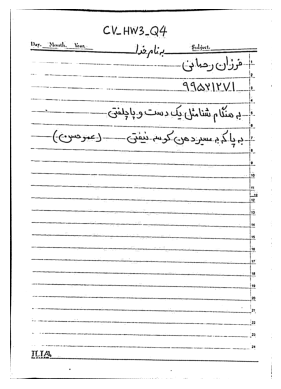

In [48]:
# using otsu thresholding
# ret, im_gray_result_1 = cv2.threshold(im_gray_result, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# smooth the image with bilateralFilter
# im_gray_result_2 = cv2.bilateralFilter(im_gray_result, 31, 40, 40)

# # smooth the image with GaussianBlur
# im_gray_result_3 = cv2.GaussianBlur(im_gray_result, (5, 5), 0)

# # smooth the image with medianBlur
# im_gray_result_4 = cv2.medianBlur(im_gray_result, 101)

# using histogram stretching
# im_gray_result_5 = cv2.normalize(im_gray_result, None, 0, 255, cv2.NORM_MINMAX)
# imshow(im_gray_result_5)

# using histogram equalization
# im_gray_result_6 = cv2.equalizeHist(im_gray_result)
# imshow(im_gray_result_6)

# using adaptiveThreshold
im_gray_result_7 = cv2.adaptiveThreshold(im_gray_result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 6)
imshow(im_gray_result_7)

<div dir="rtl">
    تلاش هایی که نتیجه بهتری داشتند. 
</div>

<Figure size 640x480 with 0 Axes>

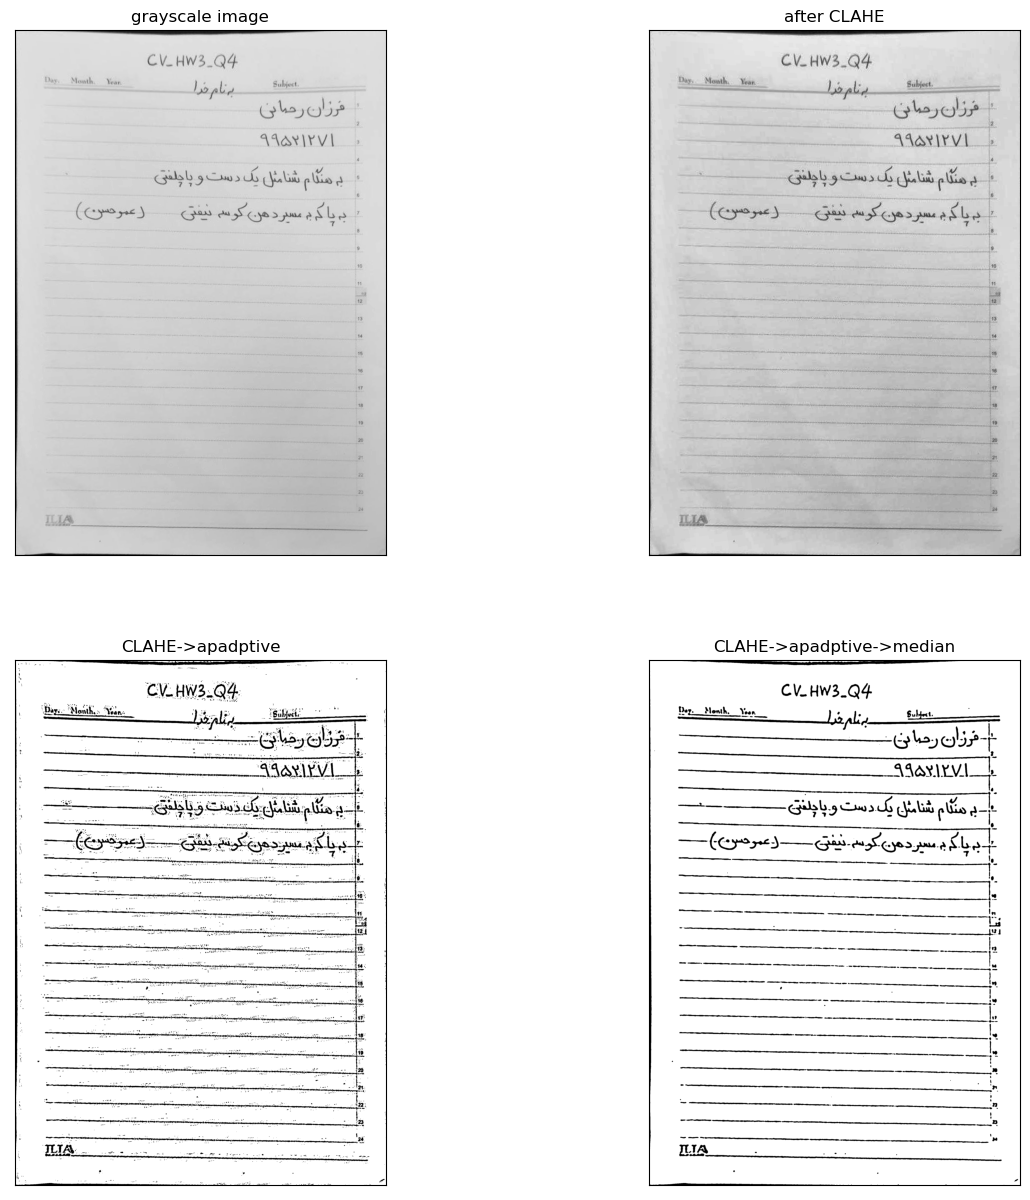

In [55]:
# better the quality of im_gray_result with CLAHE and adaptiveThreshold (otsu) 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

im_gray_result1 = clahe.apply(im_gray_result)
# im_gray_result1 = clahe.apply(im_bilateral_gray_result)
# im_gray_result1 = np.where(im_gray_result1 > 155, 255, 0)

# im_gray_result2 = cv2.adaptiveThreshold(im_gray_result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 8)
im_gray_result3 = cv2.adaptiveThreshold(im_gray_result1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 6)

im_gray_result4 = cv2.medianBlur(im_gray_result3, 11)

plt.figure()
fugure, axis = plt.subplots(2, 2, figsize=(15,15))
axis[0, 0].imshow(im_gray_result, cmap='gray')
axis[0, 0].set_title('grayscale image')
axis[0, 1].imshow(im_gray_result1, cmap='gray')
axis[0, 1].set_title('after CLAHE')
axis[1, 0].imshow(im_gray_result3, cmap='gray')
axis[1, 0].set_title('CLAHE->apadptive')
axis[1, 1].imshow(im_gray_result4, cmap='gray')
axis[1, 1].set_title('CLAHE->apadptive->median')

# remove axis numbers
for ax in axis.flat:
    ax.set(xticks=[], yticks=[])
plt.show()

<Figure size 640x480 with 0 Axes>

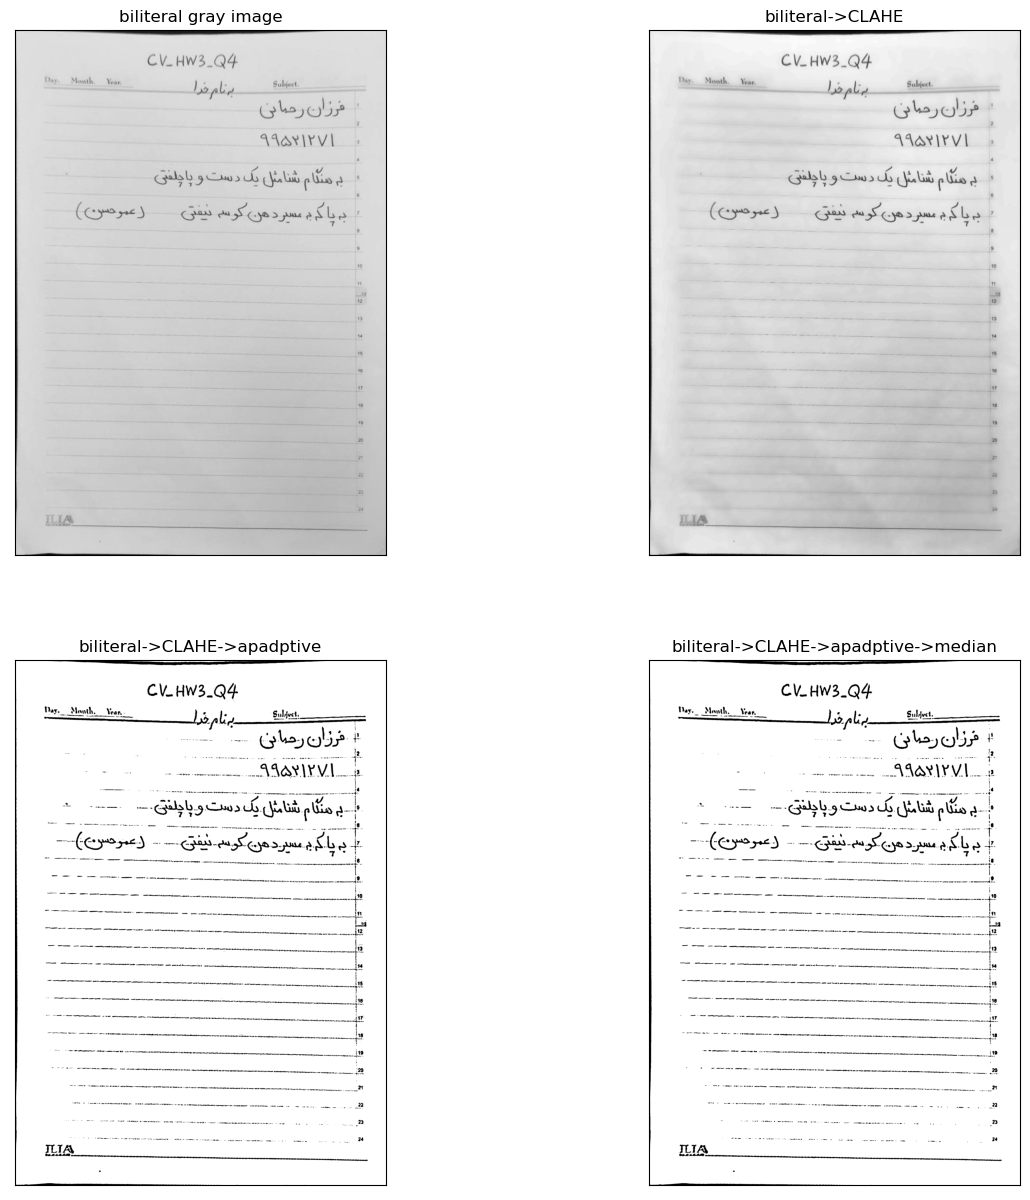

In [83]:
# better the quality of im_gray_result with CLAHE and adaptiveThreshold (otsu) 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
im_gray_result1 = clahe.apply(im_bilateral_gray_result)
im_gray_result2 = cv2.adaptiveThreshold(im_gray_result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
im_gray_result4 = cv2.medianBlur(im_gray_result3, 5)

plt.figure()
fugure, axis = plt.subplots(2, 2, figsize=(15,15))
axis[0, 0].imshow(im_gray_result, cmap='gray')
axis[0, 0].set_title('biliteral gray image')
axis[0, 1].imshow(im_gray_result1, cmap='gray')
axis[0, 1].set_title('biliteral->CLAHE')
axis[1, 0].imshow(im_gray_result3, cmap='gray')
axis[1, 0].set_title('biliteral->CLAHE->apadptive')
axis[1, 1].imshow(im_gray_result4, cmap='gray')
axis[1, 1].set_title('biliteral->CLAHE->apadptive->median')

# remove axis numbers
for ax in axis.flat:
    ax.set(xticks=[], yticks=[])
plt.show()

Text(0.5, 1.0, 'CLAHE->apadptive->biliteral')

<Figure size 640x480 with 0 Axes>

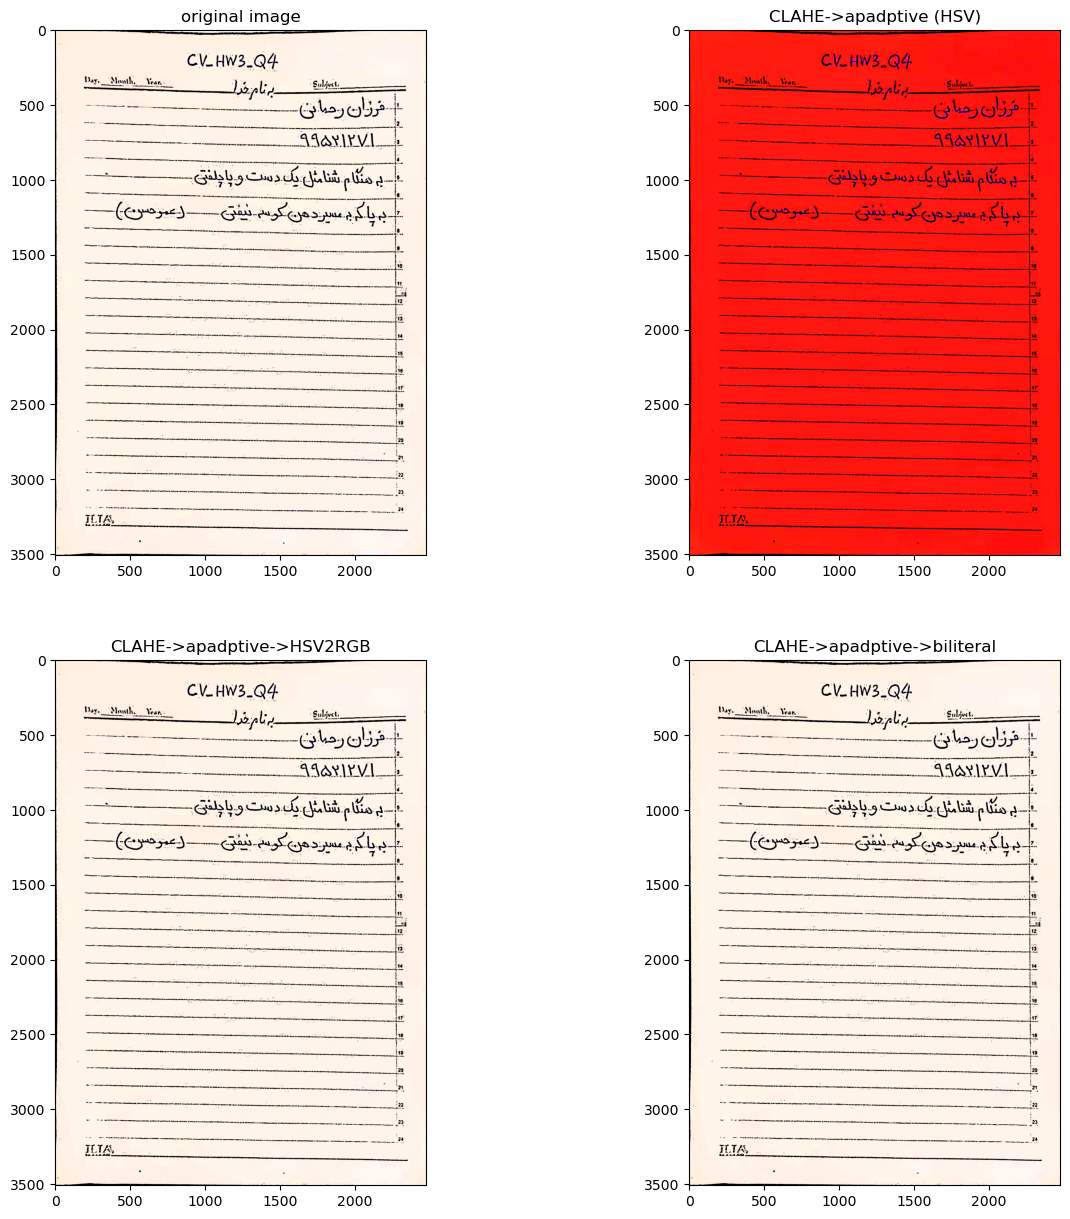

In [74]:
# better the quality of im_color_result in HSV color space with CLAHE and adaptiveThreshold (otsu)
im_color_result_hsv = cv2.cvtColor(im_color_result, cv2.COLOR_BGR2HSV)
im_color_result_hsv1 = im_color_result_hsv
im_color_result_hsv1[:,:,2] = clahe.apply(im_color_result_hsv1[:,:,2])
im_color_result_hsv2 = im_color_result_hsv1
im_color_result_hsv2[:,:,2] = cv2.adaptiveThreshold(im_color_result_hsv2[:,:,2], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 14)
# im_color_result_hsv2[:,:,2] = cv2.adaptiveThreshold(im_color_result_hsv2[:,:,2], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 15)

im_color_result = cv2.cvtColor(im_color_result_hsv2, cv2.COLOR_HSV2BGR)

# apply bilateralFilter to smooth the image
im_color_result2 = cv2.bilateralFilter(im_color_result, 21, 40, 40)

plt.figure()
fugure, axis = plt.subplots(2, 2, figsize=(15,15))
axis[0, 0].imshow(im_color_result[:,:,::-1])
axis[0, 0].set_title('original image')
axis[0, 1].imshow(im_color_result_hsv2[:,:,::-1])
axis[0, 1].set_title('CLAHE->apadptive (HSV)')
axis[1, 0].imshow(im_color_result[:,:,::-1])
axis[1, 0].set_title('CLAHE->apadptive->HSV2RGB')
axis[1, 1].imshow(im_color_result2[:,:,::-1])
axis[1, 1].set_title('CLAHE->apadptive->biliteral')